# Running DtDp PDF generator

Source environment:

In [ ]:
conda activate /home/hannah.griggs/.conda/envs/pynu-dev-23/

The dtdphase setup script (run_dtdphase.sh) lives here:

In [ ]:
/home/hannah.griggs/nu/banks/pynu_tests/skyloc/tests/dtdphase

Begin with the GPS time and approximate sky error region for the event 

Edit region variables in run_dtdphase.sh

In [ ]:
ra_min=288.75
ra_max=296.25
dec_min=-30.0
dec_max=-60.0

trig_time=1369694512.10

event_name=S230601bf

If no event name from GraceDB, give it a unique identifier.

Run the script:

In [ ]:
./run_dtdphase.sh

The output should be one L1H1 PDF

In [ ]:
--output-file ${ifos[0]}${ifos[1]}-stat-${event_name}.hdf

Keep track of this file's location, you'll have a bunch of them

If you want to visualize the PDF, you can either open it in VScode or something, or make a quick plot on CIT jupyter with something like this:

In [ ]:
import h5py
import matplotlib.pyplot as plt

filename = "/home/hannah.griggs/nu/banks/pynu_tests/skyloc/tests/dtdphase/L1H1-stat-S200128d.hdf"  
with h5py.File(filename, 'r') as f:
    # Assuming 'ifo0' is the reference IFO dataset
    param_bin = f['L1/param_bin'][:]
    weights = f['L1/weights'][:]

# Extract the parameters of interest (e.g., time and phase)
# Change these indices according to your specific parameters
param_time = param_bin['c0']
param_phase = param_bin['c1']

# Create a 2D histogram
plt.hist2d(param_time, param_phase, bins=(120, 65), weights=weights, cmap='viridis', density=True)
plt.colorbar(label="Density of source events", format='%.0e')
plt.xlabel('Time Parameter $t_{L}-t_{H}$')
plt.ylabel('Phase Parameter $\phi_{L}-\phi_{H}$')
plt.title('2D Histogram of Time vs. Phase')
plt.show()

Which should produce something that looks blobby, such as this:

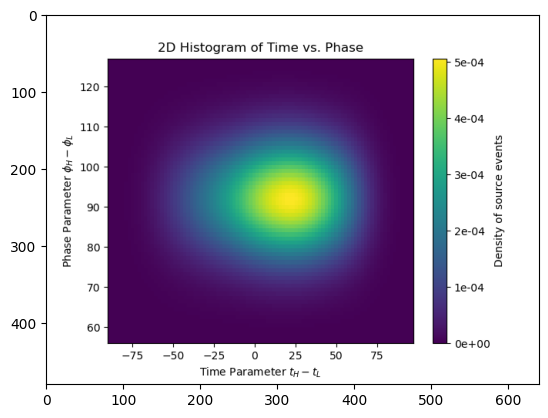

In [4]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
img = mpimg.imread('/Users/griggsks/Desktop/tpsky.png')
imgplot = plt.imshow(img)
plt.show()

# To start a PyCBC run with your new PDF:

The O4 environment we're using:

In [ ]:
conda deactivate # Get out of the (igwn) environment. Make sure to have no active environment at all before sourcing.
source /cvmfs/oasis.opensciencegrid.org/ligo/sw/pycbc/x86_64_rhel_8/virtualenv/pycbc-v2.1.3/bin/activate

## Part 1: Reusing matched filtering results from existing analyses

This can be tricky. The overarching steps are:

1. Find the corresponding offline PyCBC box, it will be in someone's directory according to (for O3) https://wiki.ligo.org/CBC/Searches/PycbcC01HlRunSchedule
2. Copy over the reuse.map file from that run directory. In there should be the paths to all of the files that could be reused for another run of PyCBC
3. Remove all files post-coinc step. That's a lot of files so you'll need to be careful about this. 

So let's break that down. First, open up the file and get ready to delete a bunch of lines. The lines we are removing represent all the output files from the coincident jobs and onward in the workflow. In other words, everything that depends on running pycbc_coinc_findtrigs. 

Things to keep in mind: 
- There is a logic to this file. It populates in order of job completion, so it's safe to assume that you want to keep everything before the first "COINC" output file shows up.
- This file follows the structure of the main.dax files. If you want to double check anything, open up the dax file in the run directory and trace where the output of the coinc jobs go. 

#### The lines you want to remove are:
1. Everything after FIT_OVER_... files until the next set of inspiral jobs start.
2. all "COINC" 
3. all "STATMAP"
4. all injection, range, coincident, followup plotting ("PLOT"). Basically all plotting except for the initial plotting that happens before inspiral jobs get started.
5. all "SNGLS COINC" stuff

O4-specifc Plus:
1. "H1L1-EXCLUDE_ZEROLAG_FULL_DATA_2DET"......hdf
2. "H1L1-FOREGROUND_CENSOR".......xml
3. "H1L1-HDFINJFIND_NSBHSEOBNRV4_INJ_INJECTIONS"........hdf
4. "H1L1-HDFINJFIND_ALL_INJECTIONS-1368975466"........hdf

It's possible I'm forgetting something so this may need to be updated.

#### The next set of files you'll need are here:

In [ ]:
/home/hannah.griggs/nu/banks/pynu_tests/skyloc/tests/run_testing/events_test/o4c1

In here are ini files for the pycbc workflow. To note here are:
1. analysis_dtdp.ini (contains adjusted dtdp pdf input line, you'll want to edit this with your custum pdf)
2. c1location (shortcut to original pycbc box, good to keep on hand as you'll be referencing the dax in there)
3. run.sh (the run script)

run.sh will need to be edited as:

In [ ]:
WORKFLOW_NAME=mmatest ## you can keep this the same
CHUNKNUMBER=1 ## Change to reflect which chunk your event is in
CONFIG_TAG=v2.3.2.3 ## Keep this
DESCRIPTION='INITIAL_OR_RERUN_OR_SOME_DESCRIPTIVE_WORD' #(NOTE: no spaces, INITIAL recommended for first run)
GITLAB_URL="https://git.ligo.org/pycbc/offline-analysis/-/raw/${CONFIG_TAG}/prouction/o4/broad/config"
ID=S230601bf_3 ## Change to reflect the unique identifier that goes with the dtdphase PDF you made

In [ ]:
kinit hannah.griggs ## Change to your ligo name

*** Make sure all the paths are for your directory!

### For jobs that will use the reuse.map file, such as these ones:

Make sure that one of the arguments for pycbc_make_offline_search_workflow is:

In [ ]:
--cache-file reuse.map \

### To use O3 data:

Download this file to replace the corresponding "data" file in the o4 run.sh file:
https://git.ligo.org/ligo-cbc/pycbc-config/-/blob/master/O3C01/pipelineHL/data_O3_C01_clean.ini

The GPS times will need to be specified. CHUNKNUMBER corresponds to the GPS time stretch, but we want O3 ones. So, 
1. Take the start and end GPS times from the O3 boxes page for your chunk
2. Edit the gps_times ini file to reflect the new start and end times AND
3. Delete the segments-dq-file entry, since O3 didn't use this.

Once that is all in place, you should be good to run 

### To run:

1. Double check that the paths are correct and that you've sourced the pycbc environment
2. Run the workflow generator:

In [ ]:
./run.sh

3. Enter necessary credentials
4. Make sure setup completes
5. Then it should be running! 

You'll need to babysit the jobs since they've been having issues with disk space and memory.
Check how the queue is doing from within the run directory with:

In [ ]:
./status

### If jobs are struggling:

1. If jobs are getting held, see the reason with:

In [ ]:
condor_q better-analyze

This will tell you which job requirements are insufficient and by how much. If memory or disk space are the problem, update held jobs like this:

In [ ]:
condor_qedit -constraint "JOBSTATUS==5" RequestDisk=newrequestamount

Change RequestDisk to RequestMemory as needed, and only request a little over what the jobs seem to need.

Release jobs again with 

In [ ]:
condor_release -constraint "JOBSTATUS==5"